<font size=4 face='黑体'>生成验证码

In [1]:
!pip install captcha

In [2]:
from captcha.image import ImageCaptcha
import numpy as np
from PIL import Image
import random
import sys
import os
import tensorflow as tf
import matplotlib.pyplot as plt

H:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
number = [str(i) for i in range(10)]
little_chr = [chr(i) for i in range(97,123)]
large_chr = [chr(i) for i in range(65,91)]
print(number)
print(little_chr)
print(large_chr)
CHAR_SET = number

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
#生成验证码
#随机生成4个字符
def  random_captcha_text(char_set=CHAR_SET,captcha_size=4):
    return ''.join(random.choices(char_set,k=captcha_size))

#生成字符串对应的验证码
def gen_captcha_text_and_image(path):
    image_ = ImageCaptcha()
    captcha_text = random_captcha_text()
    captcha = image_.generate(captcha_text)
    image_.write(captcha_text,path + captcha_text + '.jpg')
    
path = r'F:\TensorFlow-inception\captcha\images\\'
num = 10000

if not os.path.exists(path):
    os.makedirs(path)
    
for i in range(num):
    gen_captcha_text_and_image(path)
    sys.stdout.write('\r>> Creating images %d/%d' % (i+1,num))
    sys.stdout.flush()
    
sys.stdout.write('\n')
sys.stdout.flush()

>> Creating images 10000/10000


<font size=4 face='黑体'>转换为tfrecord

In [7]:
num_test = 500
random_seed = 2
data_dir = r'F:/TensorFlow-inception/captcha/images/'
tfrecord_dir = r'F:/TensorFlow-inception/captcha/'

#查看文件是否存在
def tfdata_is_exists(dataset_dir):
    for split_name in ['train','test']:
        tf_name = os.path.join(dataset_dir,split_name + '.tfrecord')
        if not tf.gfile.Exists(tf_name):
            return False
    return True

#获得每张验证码各自的路径组成的列表
def get_filenames(dataset_dir):
    captcha_names = []
    for filename in os.listdir(dataset_dir):
        path = os.path.join(dataset_dir,filename)
        captcha_names.append(path)
    return captcha_names

#转换为协议文本格式
def int64_feature(values):
    if not isinstance(values,(tuple,list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

def bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

def image_to_tfexample(image_data,label0,label1,label2,label3):
    return tf.train.Example(features=tf.train.Features(feature={
        'image':bytes_feature(image_data),
        'label0':int64_feature(label0),
        'label1':int64_feature(label1),
        'label2':int64_feature(label2),
        'label3':int64_feature(label3)
    }))

#数据转换为record格式
def convert_dataset(split_name,filenames,tfrecord_dir):
    #确保split_name在['train','test']中
    assert split_name in ['train','test']
    
    with tf.Session() as sess:
        out_tfnames = os.path.join(tfrecord_dir,split_name + '.tfrecord')
        with tf.python_io.TFRecordWriter(out_tfnames) as tf_writer:
            for i,filename in enumerate(filenames):
                try:
                    sys.stdout.write('\r>> Converting image %d/%d' % (i+1,len(filenames)))
                    sys.stdout.flush()
                    
                    image_data = Image.open(filename)
                    image_data = image_data.resize((224,224))  #为了之后多任务训练的Alexnet模型
                    image_data = image_data.convert('L').tobytes()  #转化为单通道的灰度图，并转换为bytes格式
                    
                    #拿到4位验证码并encode（）
                    labels = filename.split('/')[-1][:4]
                    example = image_to_tfexample(image_data,int(labels[0]),int(labels[1]),int(labels[2]),int(labels[3]))
                    
                    tf_writer.write(example.SerializeToString())
                    
                except IOError as e:
                    print('Wrong:' + filename)
                    print('Error:',e)
                    print('Skip it\n')
    sys.stdout.write('\n')
    sys.stdout.flush()
    
if tfdata_is_exists(tfrecord_dir):
    print('tf文件已经存在')
else:
    photo_filenames = get_filenames(data_dir)
    random.seed(random_seed)
    #打乱文件
    random.shuffle(photo_filenames)
    training_filenames = photo_filenames[num_test:]
    testing_filenames = photo_filenames[:num_test]
    
    convert_dataset('train',training_filenames,tfrecord_dir)
    convert_dataset('test',testing_filenames,tfrecord_dir)
                

>> Converting image 5803/5803
>> Converting image 500/500


<font size=4 face='黑体'>查看自己转换的是否正确

batch0:
2 7 4 5


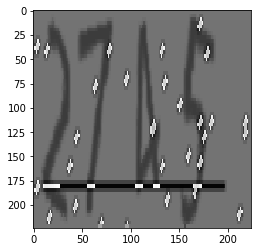

5 3 7 8


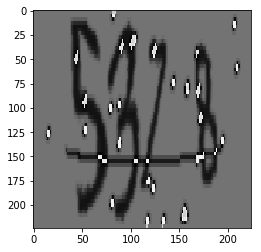

1 9 0 0


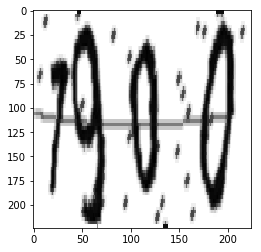

In [8]:
def read_and_decode(filename_quene, batch_size):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_quene)
    features = tf.parse_single_example(serialized_example,
                                      features={
                                          'image':tf.FixedLenFeature([], tf.string),
                                          'label0':tf.FixedLenFeature([], tf.int64),
                                          'label1':tf.FixedLenFeature([], tf.int64),
                                          'label2':tf.FixedLenFeature([], tf.int64),
                                          'label3':tf.FixedLenFeature([], tf.int64)
                                      })
    image = tf.decode_raw(features['image'], tf.int8)
    image = tf.reshape(image, [224,224])
    label0 = tf.cast(features['label0'], tf.int32)
    label1 = tf.cast(features['label1'], tf.int32)
    label2 = tf.cast(features['label2'], tf.int32)
    label3 = tf.cast(features['label3'], tf.int32)
    return image, label0, label1, label2, label3

def show_tfrecord(tf_name, batch_num,batch_size):
    filename_queue = tf.train.string_input_producer([tf_name])
    images, labels0, labels1, labels2, labels3 = read_and_decode(filename_queue,batch_size)
    images_b, labels0_b, labels1_b, labels2_b, labels3_b = tf.train.shuffle_batch([images, labels0, labels1, labels2, labels3],
                                                                                   batch_size=batch_size,
                                                                                   capacity=100,
                                                                                   num_threads=1,
                                                                                   min_after_dequeue=20)
    init_op = tf.group(tf.global_variables_initializer(),
                      tf.local_variables_initializer())
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for i in range(batch_num):
            img_, label0_, label1_, label2_, label3_ = sess.run([images_b, labels0_b, labels1_b, labels2_b, labels3_b])
            print('batch' + str(i) + ':')
            for j in range(batch_size):
                print(label0_[j],label1_[j],label2_[j],label3_[j])
                plt.imshow(img_[j],cmap='gray')
                plt.show()
        coord.request_stop()
        coord.join(threads)
        
show_tfrecord('F:/TensorFlow-inception/captcha/train.tfrecord',batch_num=1,batch_size=3)

<font size=4 face='黑体'>单任务的CNN验证码识别

<font size=4 face='黑体'>将图片转换为tfrecord

In [11]:
#验证集数量
_NUM_TEST = 100
#随机种子
_RANDOM_SEED = 0
#数据集路径
DATASET_DIR = "F:/TensorFlow-inception/images/"
#标签文件名字
LABELS_FILENAME = "labels.txt"

#判断tfrecord文件是否存在
def _dataset_exists(dataset_dir):
    for split_name in ['train', 'test']:
        output_filename = os.path.join(dataset_dir, split_name + '.tfrecord')
        if not tf.gfile.Exists(output_filename):
            return False
    return True

#获取所有文件以及分类
def _get_filenames_and_classes(dataset_dir):
    #数据目录
    directories = []
    #分类名称
    class_names = []
    for filename in os.listdir(dataset_dir):
        #合并文件路径
        path = os.path.join(dataset_dir, filename)
        #判断该路径是否为目录
        if os.path.isdir(path):
            #加入数据目录
            directories.append(path)
            #加入类别名称
            class_names.append(filename)

    photo_filenames = []
    #循环每个分类的文件夹
    for directory in directories:
        for filename in os.listdir(directory):
            path = os.path.join(directory, filename)
            #把图片加入图片列表
            photo_filenames.append(path)

    return photo_filenames, class_names

def int64_feature(values):
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))

def bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))

def image_to_tfexample(image_data, image_format, class_id):
    #Abstract base class for protocol messages.
    return tf.train.Example(features=tf.train.Features(feature={
      'image/encoded': bytes_feature(image_data),
      'image/format': bytes_feature(image_format),
      'image/class/label': int64_feature(class_id),
    }))

def write_label_file(labels_to_class_names, dataset_dir,filename=LABELS_FILENAME):
    labels_filename = os.path.join(dataset_dir, filename)
    with tf.gfile.Open(labels_filename, 'w') as f:
        for label in labels_to_class_names:
            class_name = labels_to_class_names[label]
            f.write('%d:%s\n' % (label, class_name))

#把数据转为TFRecord格式
def _convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir):
    assert split_name in ['train', 'test']
    with tf.Graph().as_default():
        with tf.Session() as sess:
            #定义tfrecord文件的路径+名字
            output_filename = os.path.join(dataset_dir, split_name + '.tfrecord')
            with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                for i,filename in enumerate(filenames):
                    try:
                        sys.stdout.write('\r>> Converting image %d/%d' % (i+1, len(filenames)))
                        sys.stdout.flush()
                        #读取图片
                        image_data = tf.gfile.FastGFile(filename, 'rb').read()
                        #获得图片的类别名称
                        class_name = os.path.basename(os.path.dirname(filename))
                        #找到类别名称对应的id
                        class_id = class_names_to_ids[class_name]
                        #生成tfrecord文件
                        example = image_to_tfexample(image_data, b'jpg', class_id)
                        tfrecord_writer.write(example.SerializeToString())
                    except IOError as e:
                        print("Could not read:",filename)
                        print("Error:",e)
                        print("Skip it\n")
                            
    sys.stdout.write('\n')
    sys.stdout.flush()


if __name__ == '__main__':
    if _dataset_exists(DATASET_DIR):
        print('tfcecord文件已存在')
    else:
        #获得所有图片以及分类
        photo_filenames, class_names = _get_filenames_and_classes(DATASET_DIR)
        #把分类转为字典格式，类似于{'house': 3, 'flower': 1, 'plane': 4, 'guitar': 2, 'animal': 0}
        class_names_to_ids = dict(zip(class_names, range(len(class_names))))

        #把数据切分为训练集和测试集
        random.seed(_RANDOM_SEED)
        random.shuffle(photo_filenames)
        training_filenames = photo_filenames[_NUM_TEST:]
        testing_filenames = photo_filenames[:_NUM_TEST]

        #数据转换
        _convert_dataset('train', training_filenames, class_names_to_ids, DATASET_DIR)
        _convert_dataset('test', testing_filenames, class_names_to_ids, DATASET_DIR)

        #输出labels文件
        labels_to_class_names = dict(zip(range(len(class_names)), class_names))
        write_label_file(labels_to_class_names, DATASET_DIR)

>> Converting image 476/476
>> Converting image 100/100
